## Convolutional networks for track finding on 1D detector planes

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred, draw_train_history
from metrics import calc_hit_accuracy

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Utilities

In [2]:
def draw_2d_filters(filters, figsize=(9,3), ncols=4):
    plt.figure(figsize=figsize)
    nrows = filters.shape[0] / ncols
    for i in range(nrows):
        for j in range(ncols):
            fidx = i * ncols + j
            plt.subplot(nrows, ncols, fidx + 1)
            plt.imshow(filters[fidx].T, interpolation='none', cmap='coolwarm')
            plt.axis('off')

## Data generation

In [3]:
# Config parameters
det_width = 48
det_depth = 48
det_shape = (det_depth, det_width)
seed_size = 5
num_events = 102400
num_bkg_tracks = 5
noise_prob = 0.2

In [4]:
# Signal tracks
tracks = generate_straight_tracks(num_events, det_shape)
# Background tracks
bkgs = generate_track_bkg(num_events, det_shape,
                          tracks_per_event=num_bkg_tracks, skip_layers=seed_size)
# Noise
noise = generate_uniform_noise(num_events, det_shape,
                               prob=noise_prob, skip_layers=seed_size)

## Model definitions

In [5]:
def build_conv_model(shape, num_layers=10, num_filters=8):
    """Build the simple convolutional model"""
    inputs = layers.Input(shape=shape)
    # Need a 'channel' dimension for 2D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)
    # Convolutional layers
    for _ in range(num_layers):
        hidden = layers.Conv2D(num_filters, 3, 3, border_mode='same', activation='relu')(hidden)
    conv_args = dict(border_mode='same', activation='relu')
    # Final convolution without activation
    hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    # Reshape to drop the channel dimension
    hidden = layers.Reshape((shape[0], shape[1]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

def build_convae_model(shape):
    inputs = layers.Input(shape=shape)
    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)
    # Convolutions and down-sampling
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    # Convolutions and up-sampling
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    # Final convolution without activation
    hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    # Reshape to drop the channel dimension
    hidden = layers.Reshape((shape[0], shape[1]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Training on multi-track events

In [6]:
events = tracks + bkgs
events[events>1] = 1
train2_input = events
train2_target = tracks

In [25]:
# Training config
batch_size = 128
num_epochs = 10
val_frac = 0.2

# Build and train the model
model2 = build_conv_model(det_shape)
history2 = model2.fit(train2_input, train2_target, batch_size=batch_size,
                      nb_epoch=num_epochs, validation_split=val_frac)

# Get the training set predictions
train2_pred = model2.predict(train2_input)

Train on 40960 samples, validate on 10240 samples
Epoch 1/10
40960/40960 [==============================] - 58s - loss: 1.7162 - acc: 0.3211 - val_loss: 1.4569 - val_acc: 0.3609
Epoch 2/10
40960/40960 [==============================] - 57s - loss: 1.4157 - acc: 0.3787 - val_loss: 1.3410 - val_acc: 0.4009
Epoch 3/10
40960/40960 [==============================] - 58s - loss: 1.3112 - acc: 0.4119 - val_loss: 1.2811 - val_acc: 0.4196
Epoch 4/10
40960/40960 [==============================] - 58s - loss: 1.2704 - acc: 0.4260 - val_loss: 1.3120 - val_acc: 0.4149
Epoch 5/10
40960/40960 [==============================] - 58s - loss: 1.2475 - acc: 0.4346 - val_loss: 1.2418 - val_acc: 0.4363
Epoch 6/10
40960/40960 [==============================] - 58s - loss: 1.2336 - acc: 0.4402 - val_loss: 1.2278 - val_acc: 0.4445
Epoch 7/10
40960/40960 [==============================] - 58s - loss: 1.2243 - acc: 0.4432 - val_loss: 1.2258 - val_acc: 0.4430
Epoch 8/10
40960/40960 [==============================

<IPython.core.display.Javascript object>


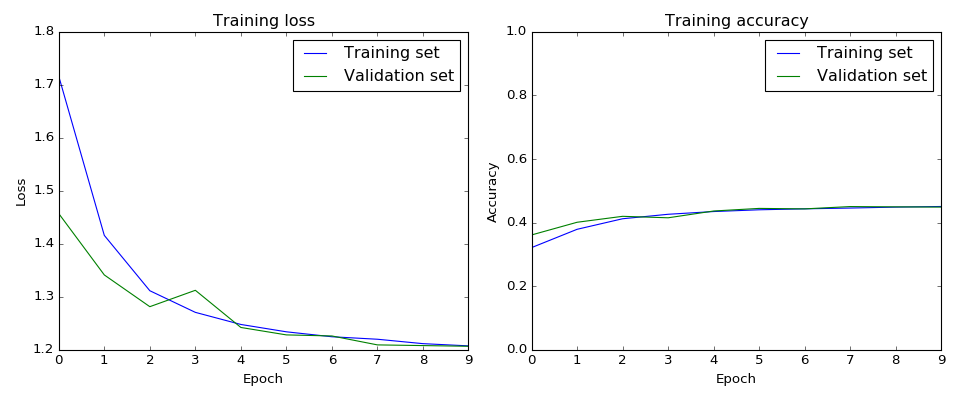

In [28]:
draw_train_history(history2);

<IPython.core.display.Javascript object>


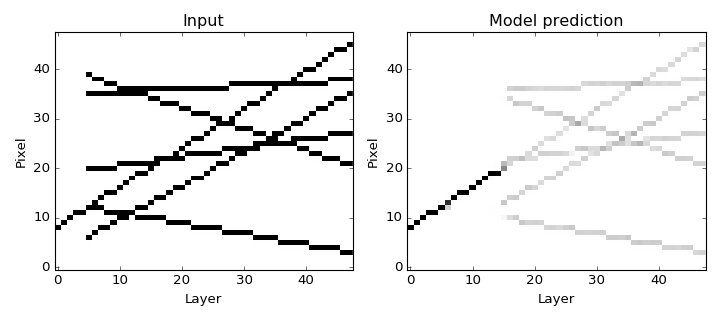

<IPython.core.display.Javascript object>


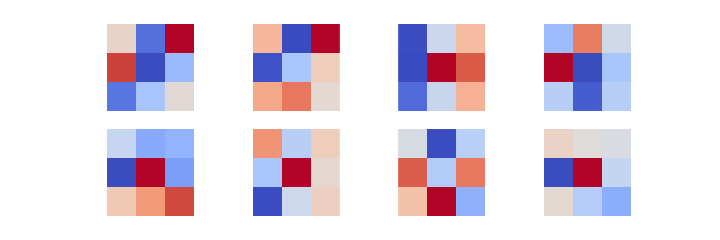

In [29]:
i = 0
draw_2d_input_and_pred(train2_input[i], train2_pred[i], cmap='gray_r')
draw_2d_filters(np.squeeze(model2.get_weights()[0]))

In [32]:
# Try a deeper model
train3_input = train2_input
train3_target = train2_target
model3 = build_conv_model(det_shape, num_layers=20)
model3.fit(train3_input, train3_target, batch_size=batch_size,
           nb_epoch=num_epochs, validation_split=val_frac)
train3_pred = model3.predict(train3_input)

Train on 40960 samples, validate on 10240 samples
Epoch 1/10
40960/40960 [==============================] - 114s - loss: 1.9392 - acc: 0.3109 - val_loss: 1.4316 - val_acc: 0.4243
Epoch 2/10
40960/40960 [==============================] - 114s - loss: 1.3161 - acc: 0.4451 - val_loss: 1.2107 - val_acc: 0.4678
Epoch 3/10
40960/40960 [==============================] - 114s - loss: 1.1767 - acc: 0.4828 - val_loss: 1.1114 - val_acc: 0.4995
Epoch 4/10
40960/40960 [==============================] - 114s - loss: 1.0970 - acc: 0.5075 - val_loss: 1.0496 - val_acc: 0.5276
Epoch 5/10
40960/40960 [==============================] - 114s - loss: 1.1254 - acc: 0.5154 - val_loss: 1.1902 - val_acc: 0.4972
Epoch 6/10
40960/40960 [==============================] - 114s - loss: 1.0635 - acc: 0.5289 - val_loss: 1.0165 - val_acc: 0.5442
Epoch 7/10
40960/40960 [==============================] - 114s - loss: 1.0087 - acc: 0.5480 - val_loss: 0.9939 - val_acc: 0.5491
Epoch 8/10
40960/40960 [=======================

<IPython.core.display.Javascript object>


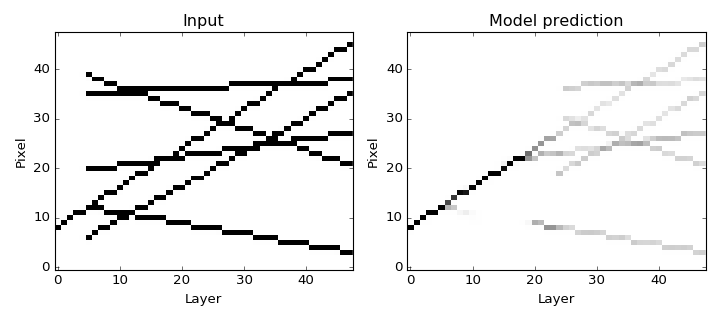

<IPython.core.display.Javascript object>


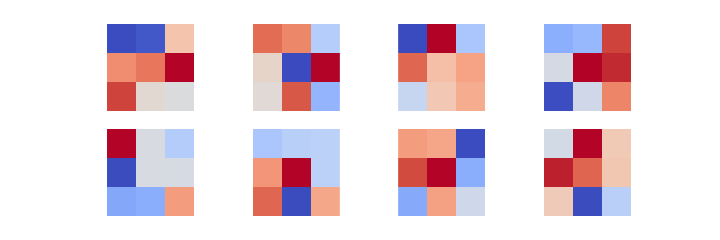

In [34]:
i = 0
draw_2d_input_and_pred(train3_input[i], train3_pred[i], cmap='gray_r')
draw_2d_filters(np.squeeze(model3.get_weights()[0]))

## Train a convolutional autoencoder

In [11]:
# Training config
batch_size = 128
num_epochs = 20
val_frac = 0.1

# Prepare the model
train4_input = events
train4_target = tracks
model4 = build_convae_model(det_shape)
model4.summary()

# Train the model
history4 = model4.fit(train4_input, train4_target, batch_size=batch_size,
                      nb_epoch=num_epochs, validation_split=val_frac)
train4_pred = model4.predict(train4_input)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 48, 48)        0                                            
____________________________________________________________________________________________________
reshape_3 (Reshape)              (None, 1, 48, 48)     0           input_2[0][0]                    
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 8, 48, 48)     80          reshape_3[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 8, 24, 24)     0           convolution2d_10[0][0]           
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


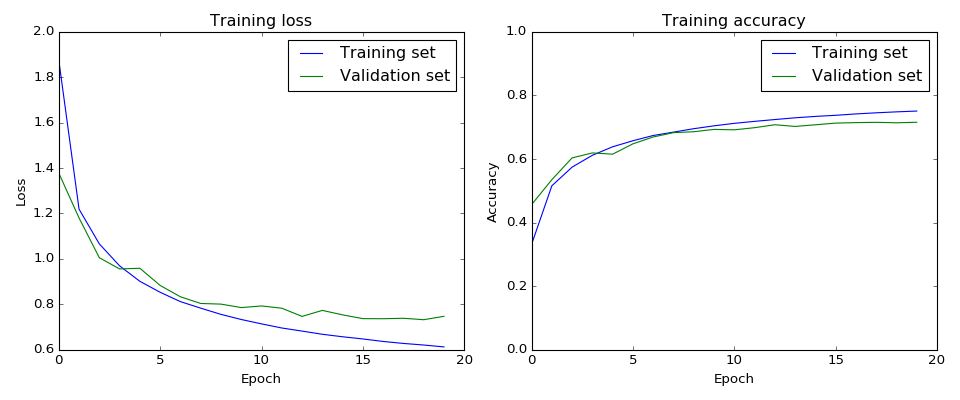

In [12]:
draw_train_history(history4);

<IPython.core.display.Javascript object>


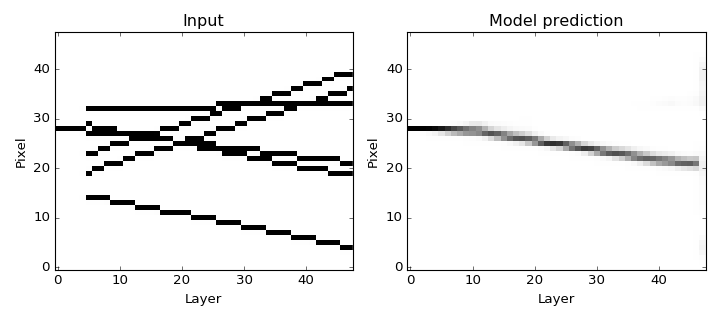

<IPython.core.display.Javascript object>


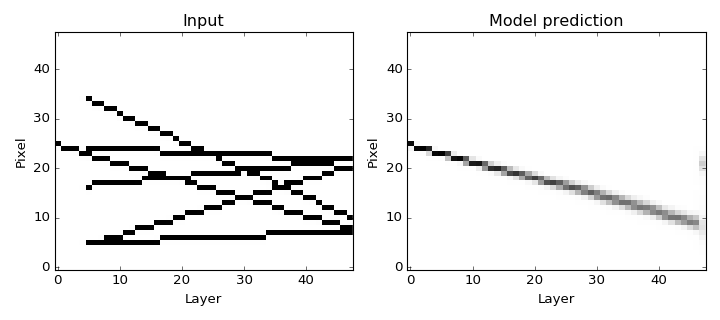

<IPython.core.display.Javascript object>


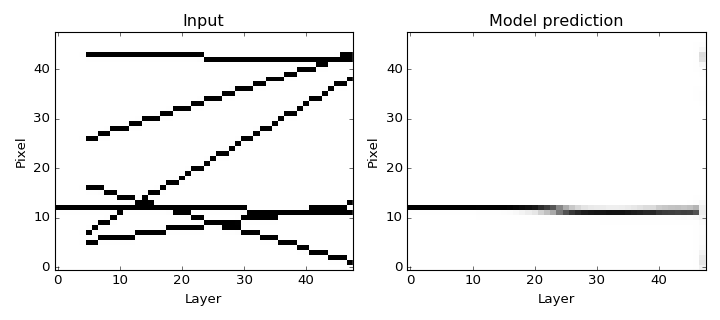

<IPython.core.display.Javascript object>


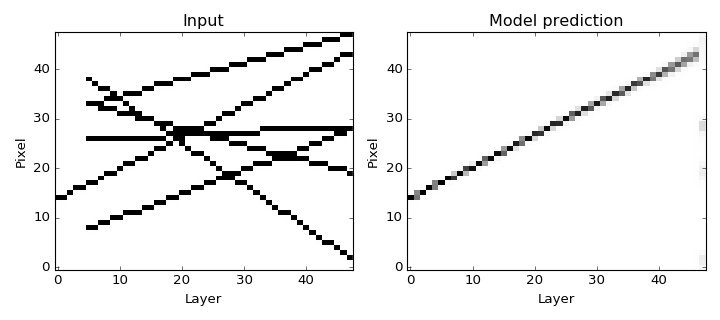

<IPython.core.display.Javascript object>


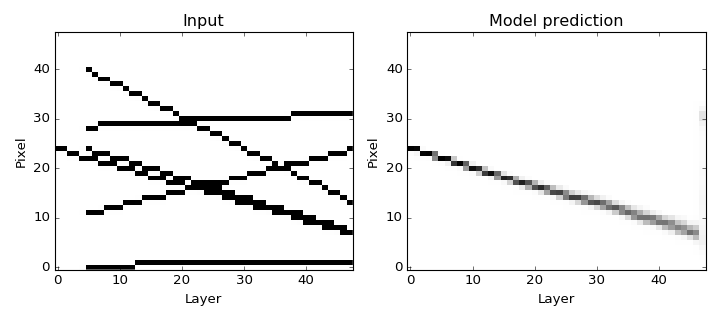

In [17]:
for i in range(5):
    draw_2d_input_and_pred(train4_input[i], train4_pred[i], cmap='gray_r');

<IPython.core.display.Javascript object>


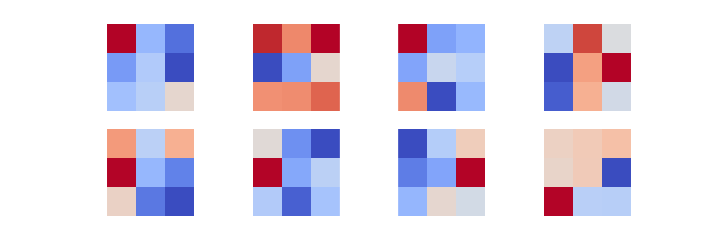

In [16]:
draw_2d_filters(np.squeeze(model4.get_weights()[0]));

Hmmm, since this one is over-training, maybe I should try it out on a test dataset. Or I could try to setup a batch generator and train the shit out of it.

In [19]:
# Generate a test dataset
num_test = 10240
test_tracks = generate_straight_tracks(num_test, det_shape)
test_bkgs = generate_track_bkg(num_test, det_shape,
                               tracks_per_event=num_bkg_tracks,
                               skip_layers=seed_size)
test_events = test_tracks + test_bkgs
test_events[test_events > 1] = 1

In [21]:
test_pred = model4.predict(test_events)

In [28]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_pred, test_tracks,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test_scores = test_pred * test_events
hit_accuracy = calc_hit_accuracy(test_scores, test_tracks)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.687926962209
Accuracy of classified hit:  0.905303955078
